# 2. Linear Regression Analysis

## Setup

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline 

In [2]:
# Load data
ames_clean = pd.read_csv('data/Ames_Housing_Price_Data_clean.csv')

In [3]:
# Create the independent variables and the target
predictors = ames_clean.drop('SalePrice', axis=1)
target = ames_clean['SalePrice']

In [4]:
print(predictors.columns.sort_values())

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

In [5]:
# Categorize columns of the independent variables
numeric_columns = predictors.select_dtypes(['int64', 'float64']).columns
categorical_columns = predictors.columns.difference(numeric_columns)

## Key Assumptions of Linear Regression

Linear Regression has several key assumptions:
1. **Linearity** - there should be a linear relationship between the independent (predictor) variables and the dependent (response) variable
2. **Independence of Errors** - residuals should be independent of each other with no correlation
3. **Homoscedasticity** - residuals should have constant variance across the range of predicted values
4. **Normality of errors** - residuals should be approximiately normally distributed
5. **No or little multicollinearity** - independent variables should not be highly correlated with each other

## Check for Multicollinearity

We will check for multicollinearity first given the large number of features

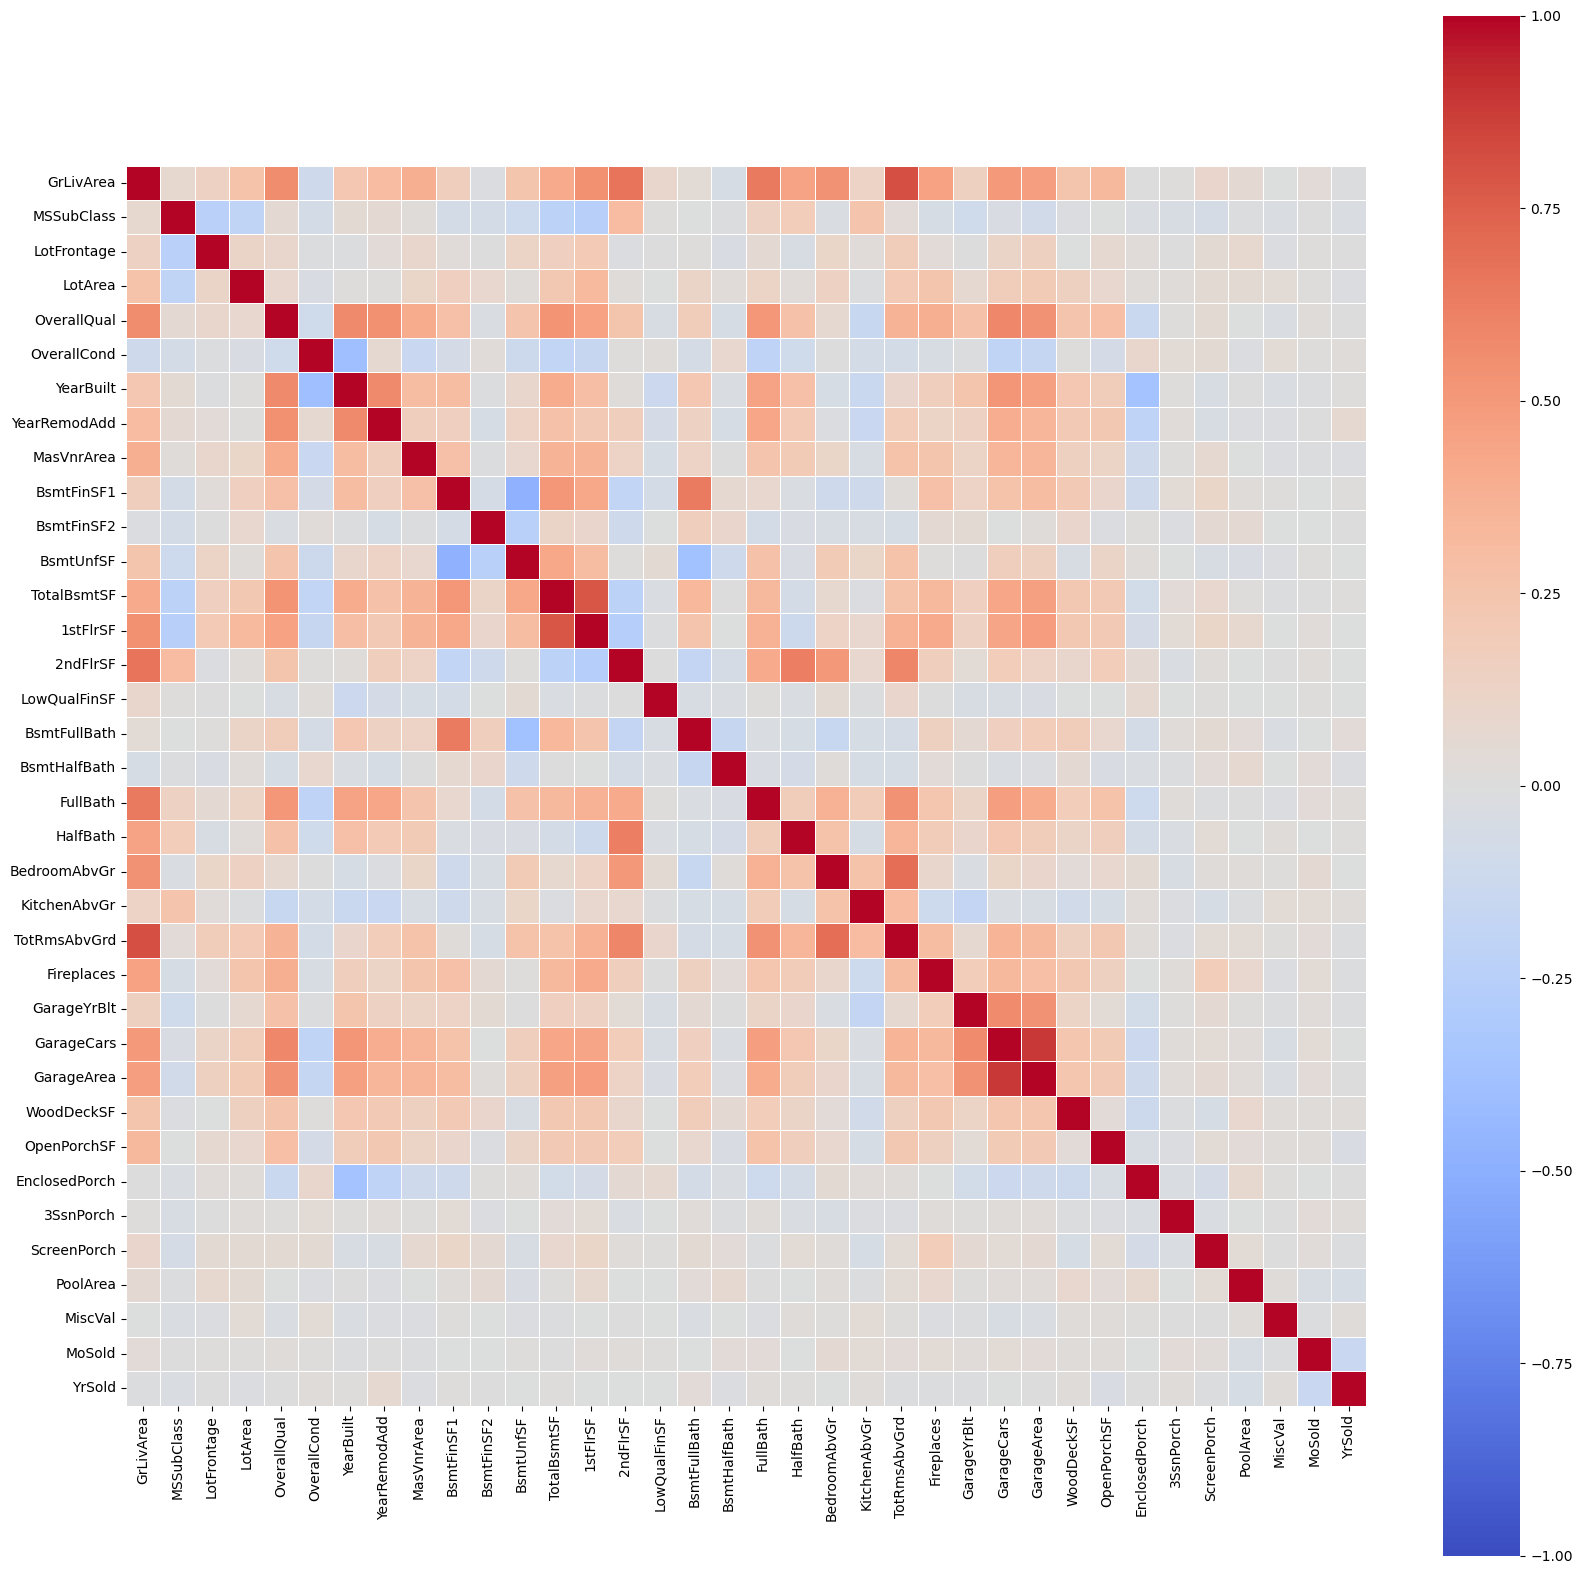

In [6]:
# Plot the correlation matrix
correlation_matrix = predictors.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, square=True, cmap='coolwarm', fmt='.2f', vmax=1.0, vmin=-1.0, linewidths=0.5)
plt.show()

In [7]:
# Calculate the variance inflation factor (VIF) for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(predictors.loc[:,numeric_columns].values, i) 
              for i in range(predictors.loc[:,numeric_columns].shape[1])]

# Print the column names and their VIF values
vif = vif.assign(Feature=predictors[numeric_columns].columns)
vif.sort_values(by='VIF', ascending=False, inplace=True)
print(vif)

             VIF        Feature
0            inf      GrLivArea
9            inf     BsmtFinSF1
15           inf   LowQualFinSF
14           inf       2ndFlrSF
13           inf       1stFlrSF
12           inf    TotalBsmtSF
11           inf      BsmtUnfSF
10           inf     BsmtFinSF2
35  2.187306e+04         YrSold
7   2.050288e+04   YearRemodAdd
6   1.601022e+04      YearBuilt
22  8.192805e+01   TotRmsAbvGrd
4   6.161835e+01    OverallQual
21  4.355915e+01   KitchenAbvGr
5   4.122175e+01    OverallCond
25  4.079507e+01     GarageCars
24  3.375221e+01    GarageYrBlt
26  3.265976e+01     GarageArea
20  3.150878e+01   BedroomAbvGr
18  2.513003e+01       FullBath
34  6.415666e+00         MoSold
2   4.388902e+00    LotFrontage
1   4.243464e+00     MSSubClass
16  3.624166e+00   BsmtFullBath
19  3.451496e+00       HalfBath
3   3.116483e+00        LotArea
23  2.926793e+00     Fireplaces
27  1.903430e+00     WoodDeckSF
8   1.810977e+00     MasVnrArea
28  1.778288e+00    OpenPorchSF
29  1.37

/Users/georgeho/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


## Feature Engineering and Selection

Given the significant presence of multicollinearity, we will build the feature set "bottoms up."  One way to do that is relying upon domain expertise.

See:  https://www.opendoor.com/articles/factors-that-influence-home-value

This article lists several features that "conventional wisdom" deems important in determining a home's value:
1. Location
2. Home size and usable space
3. Age and condition
4. Upgrades and updates
5. The local market
6. Economic indicators
7. Interest rates

We will look for proxy variables in the dataset for each one, testing for (a) predictive performance and (b) minimization of multicollinearity on the whole set.

In [11]:
# Create linear regression object
lr = LinearRegression()

**Location proxy features**

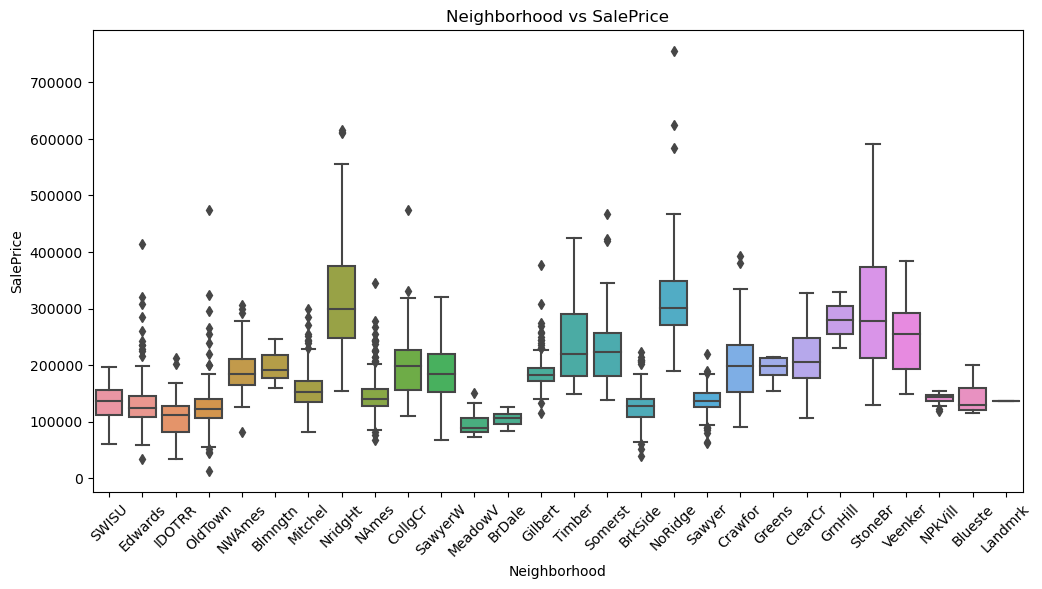

In [12]:
# Create a box plot of SalePrice for each neighborhood
plt.figure(figsize=(12, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=ames_clean)

# Label the plot
plt.title('Neighborhood vs SalePrice')
plt.xlabel('Neighborhood')
plt.ylabel('SalePrice')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [13]:
# Dummify the 'Neighborhood' column
neighborhood_dummies = pd.get_dummies(predictors['Neighborhood'], prefix='Neighborhood')

# Drop the first column of neighborhood_dummies
neighborhood_dummies = neighborhood_dummies.drop('Neighborhood_Blmngtn', axis=1)

neighborhood_dummies.head()

,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Fit the model
lr.fit(neighborhood_dummies, target)

# Show the R^2 score
lr.score(neighborhood_dummies, target)

0.5598045031837189

**Home Size and Usable Space proxy features**

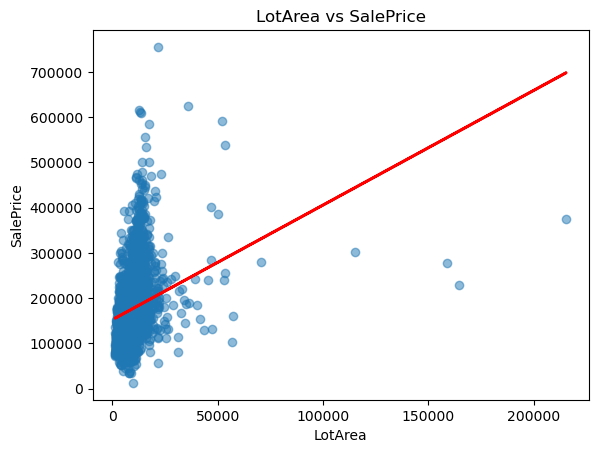

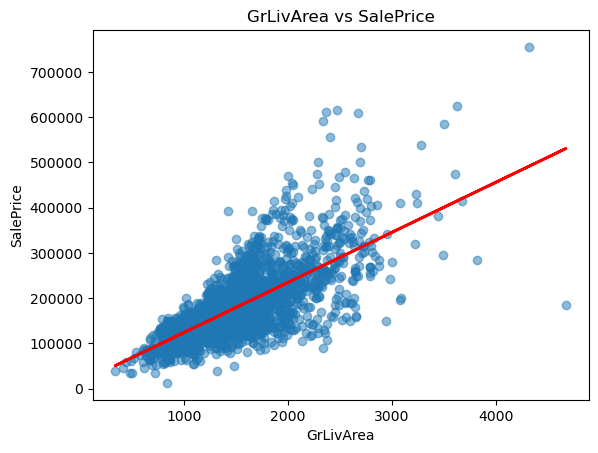

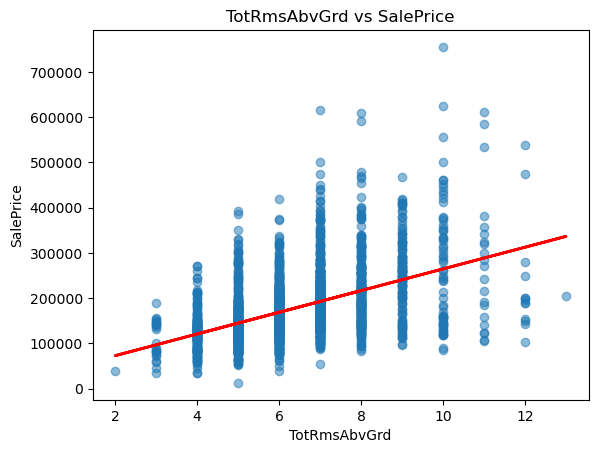

{'LotArea': 0.07531013997565805, 'GrLivArea': 0.5183711142112821, 'TotRmsAbvGrd': 0.24030189701253812}


In [15]:
# Home Size and Usable Space proxy feature

# Set up list of proxy features for home size and usable space
features_size = ['LotArea', 'GrLivArea', 'TotRmsAbvGrd']

scores = {}
for feature in features_size:
    # Fit the model
    lr.fit(predictors[[feature]], target)

    # Record scores
    scores[feature] = lr.score(predictors[[feature]], target)

    # Create scatter plot
    plt.scatter(predictors[[feature]], target, alpha=0.5)

    # Plot the regression line
    plt.plot(predictors[[feature]], lr.predict(predictors[[feature]]), color='red', linewidth=2)

    # Label the plot
    plt.title(f'{feature} vs SalePrice')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')

    # Show the plot
    plt.show()

# Show scores
print(scores)


**Age proxy features**

In [20]:
# Create a new feature representing YearsSinceBuilt
age = max(predictors['YearBuilt']) - predictors['YearBuilt']
temp = pd.DataFrame({'YearsSinceBuilt': age})

In [21]:
# Fit the model
lr.fit(temp, target)

# Show the R^2 score
lr.score(temp, target)

0.2965550613346397

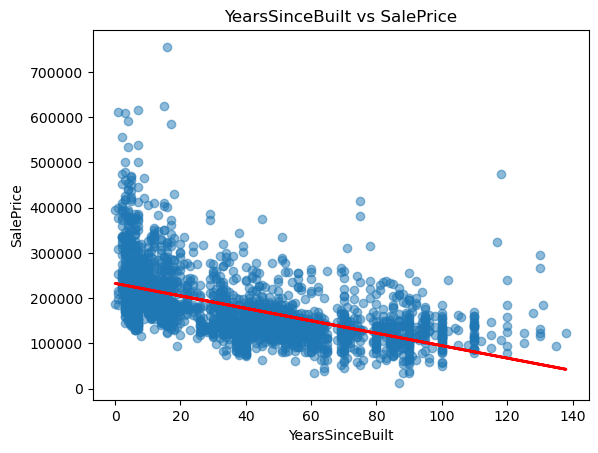

In [25]:
# Create scatter plot
plt.scatter(temp['YearsSinceBuilt'], target, alpha=0.5)

# Plot the regression line
plt.plot(temp['YearsSinceBuilt'], lr.predict(temp), color='red', linewidth=2)

# Label the plot
plt.title('YearsSinceBuilt vs SalePrice')
plt.xlabel('YearsSinceBuilt')
plt.ylabel('SalePrice')

# Show the plot
plt.show()

**Condition proxy features**

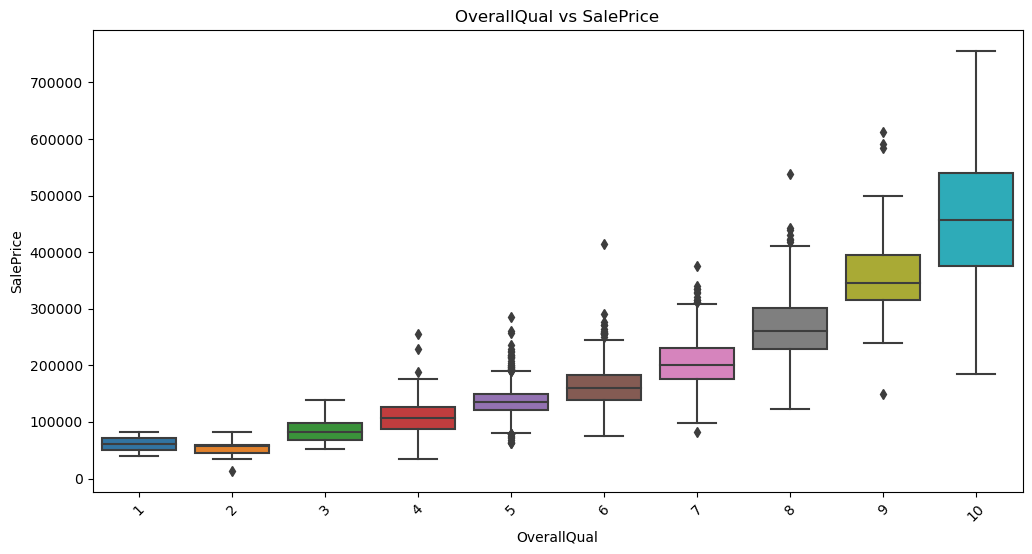

In [22]:
# Create a box plot of SalePrice vs. OverallQual
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=ames_clean)

# Label the plot
plt.title('OverallQual vs SalePrice')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

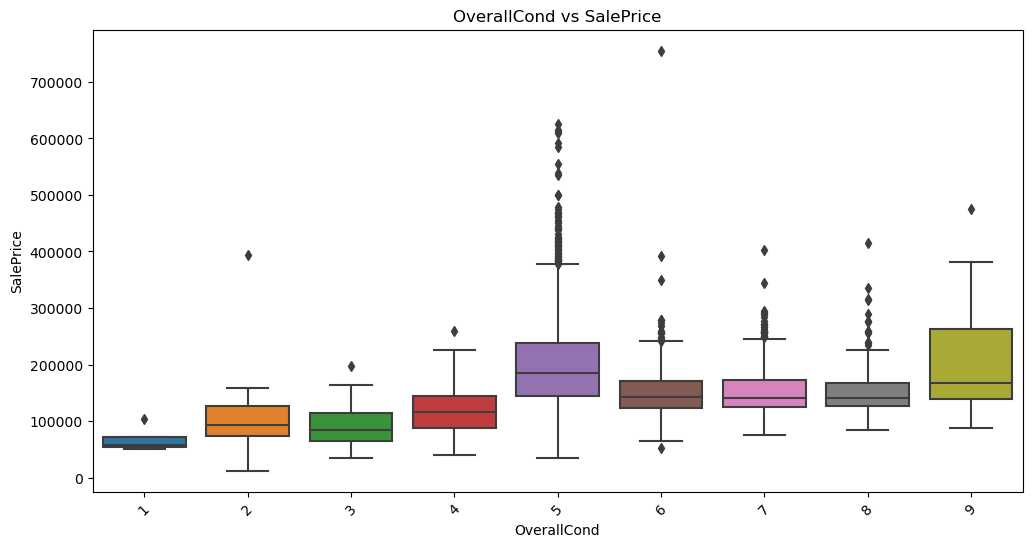

In [26]:
# Create a box plot of SalePrice vs. OverallCond
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallCond', y='SalePrice', data=ames_clean)

# Label the plot
plt.title('OverallCond vs SalePrice')
plt.xlabel('OverallCond')
plt.ylabel('SalePrice')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [28]:
# Dummify the 'OverallQual' column
overall_qual_dummies = pd.get_dummies(predictors['OverallQual'], prefix='OverallQual')

# Drop the first column of overall_qual_dummies
overall_qual_dummies = overall_qual_dummies.drop('OverallQual_1', axis=1)

overall_qual_dummies.head()

,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10
0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


In [29]:
# Fit the model
lr.fit(overall_qual_dummies, target)

# Show the R^2 score
lr.score(overall_qual_dummies, target)

0.6888112865607101

------

**Add Engineered Features to Dataframe**

In [83]:
# Make a copy of the original predictors dataframe
predictors_eng = predictors.copy()

# Add neighborhood_dummies to the dataframe and drop original variable
predictors_eng = pd.concat([predictors_eng, neighborhood_dummies], axis=1)
predictors_eng.drop('Neighborhood', axis=1, inplace=True)

# Combine the engineered features back to the target dataframe
ames_eng = pd.concat([predictors_eng, target], axis=1)

# Save the engineered dataset to a csv file
ames_eng.to_csv('data/Ames_Housing_Price_Data_eng.csv', index=False)

In [98]:
for column_name in sorted(ames_eng.columns):
    print(column_name)

1stFlrSF
2ndFlrSF
3SsnPorch
Alley
BedroomAbvGr
BldgType
BsmtCond
BsmtExposure
BsmtFinSF1
BsmtFinSF2
BsmtFinType1
BsmtFinType2
BsmtFullBath
BsmtHalfBath
BsmtQual
BsmtUnfSF
CentralAir
Condition1
Condition2
Electrical
EnclosedPorch
ExterCond
ExterQual
Exterior1st
Exterior2nd
Fence
FireplaceQu
Fireplaces
Foundation
FullBath
Functional
GarageArea
GarageCars
GarageCond
GarageFinish
GarageQual
GarageType
GarageYrBlt
GrLivArea
HalfBath
Heating
HeatingQC
HouseStyle
KitchenAbvGr
KitchenQual
LandContour
LandSlope
LotArea
LotConfig
LotFrontage
LotShape
LowQualFinSF
MSSubClass
MSZoning
MasVnrArea
MasVnrType
MiscFeature
MiscVal
MoSold
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_Greens
Neighborhood_GrnHill
Neighborhood_IDOTRR
Neighborhood_Landmrk
Neighborhood_MeadowV
Neighborhood_Mitchel
Neighborhood_NAmes
Neighborhood_NPkVill
Neighborhood_NWAmes
Neighborhood_NoRidge

**Gather the Best Features**

In [99]:
# Create features based on best R^2 scores from each category
selected_features = pd.concat([neighborhood_dummies, predictors_eng[['GrLivArea']]], axis=1)


In [100]:
print(selected_features.columns.sort_values())

Index(['GrLivArea', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR',
       'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker'],
      dtype='object')


**Check for Multi-Collinearity**

In [101]:
# Calculate the VIF for each feature in the selected_features DataFrame
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(selected_features.values, i)
              for i in range(selected_features.shape[1])]

# Add the feature names to the VIF DataFrame
vif['Feature'] = selected_features.columns

# Sort the VIF DataFrame by VIF values in descending order
vif = vif.sort_values(by='VIF', ascending=False)

# Print the VIF DataFrame
print(vif)


          VIF               Feature
27  13.037998             GrLivArea
14   2.403416    Neighborhood_NAmes
4    2.063984  Neighborhood_CollgCr
18   1.922063  Neighborhood_NridgHt
19   1.897373  Neighborhood_OldTown
17   1.832920  Neighborhood_NoRidge
7    1.782022  Neighborhood_Gilbert
23   1.763284  Neighborhood_Somerst
16   1.733707   Neighborhood_NWAmes
22   1.614886  Neighborhood_SawyerW
6    1.589999  Neighborhood_Edwards
5    1.552518  Neighborhood_Crawfor
21   1.404652   Neighborhood_Sawyer
13   1.364931  Neighborhood_Mitchel
2    1.326130  Neighborhood_BrkSide
25   1.322217   Neighborhood_Timber
24   1.301353  Neighborhood_StoneBr
3    1.261024  Neighborhood_ClearCr
10   1.241316   Neighborhood_IDOTRR
20   1.219383    Neighborhood_SWISU
26   1.152263  Neighborhood_Veenker
12   1.081644  Neighborhood_MeadowV
1    1.074050   Neighborhood_BrDale
15   1.071256  Neighborhood_NPkVill
0    1.027788  Neighborhood_Blueste
8    1.022136   Neighborhood_Greens
9    1.008082  Neighborhood_

In [102]:
# Calculate the correlation matrix
correlation_matrix = selected_features.corr()

# Get the correlation coefficients of GrLivArea with other variables
grlivarea_correlations = correlation_matrix['GrLivArea']

# Sort the correlations by their absolute values in descending order
sorted_correlations = grlivarea_correlations.abs().sort_values(ascending=False)

# Print the sorted correlations
print(sorted_correlations)


GrLivArea               1.000000
Neighborhood_NoRidge    0.323194
Neighborhood_NridgHt    0.197303
Neighborhood_NAmes      0.176909
Neighborhood_Sawyer     0.146023
Neighborhood_BrkSide    0.103526
Neighborhood_NWAmes     0.097639
Neighborhood_MeadowV    0.096485
Neighborhood_StoneBr    0.094809
Neighborhood_Edwards    0.091178
Neighborhood_IDOTRR     0.087826
Neighborhood_Crawfor    0.086184
Neighborhood_BrDale     0.081682
Neighborhood_Mitchel    0.076670
Neighborhood_ClearCr    0.074808
Neighborhood_Gilbert    0.069891
Neighborhood_Timber     0.063885
Neighborhood_Somerst    0.060168
Neighborhood_SawyerW    0.059974
Neighborhood_Veenker    0.059027
Neighborhood_NPkVill    0.044402
Neighborhood_Blueste    0.041657
Neighborhood_Greens     0.037524
Neighborhood_OldTown    0.035607
Neighborhood_SWISU      0.027398
Neighborhood_Landmrk    0.006689
Neighborhood_CollgCr    0.005701
Neighborhood_GrnHill    0.004986
Name: GrLivArea, dtype: float64
